In [3]:
import pandas as pd 
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv("C:\\Users\\norma\\OneDrive\\Desktop\\PYTHON\\Novichok_Project\\novichok_356_cross_validation\\data\\csv\\dataset_no_imaginary.csv",delimiter=",",encoding="utf-8")

In [5]:
# Создал функцию, которая проходит по директории и читает наши '.xyz'-файлы
# Название каждого файла в моей директории отражено в датасете в столбце 'name' без расширения .xyz 
# Сконвертировал координаты в numpy-массив и закинул в новый столбец 'coordinates' в датасете

coordinates_list = []

def read_xyz_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()[2:]  
        coordinates = []
        for line in lines:
            parts = line.split()
            if len(parts) == 4:
                coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])
        return np.array(coordinates)

for index, row in data.iterrows():
    file_name = str(row['name']) + ".xyz"
    file_path = os.path.join("C:\\Users\\norma\\OneDrive\\Desktop\\PYTHON\\Novichok_Project\\novichok_356_cross_validation\\xyz", file_name)
    coordinates = read_xyz_file(file_path)
    coordinates_list.append(coordinates)
data['coordinates'] = coordinates_list

In [6]:
data

,name,hf_gibbs_free_energy_ev,hf_electronic_energy_ev,hf_entropy_ev,hf_enthalpy_ev,hf_dipole_moment,hf_homo_ev,hf_lumo_ev,dft_gibbs_free_energy_ev,dft_electronic_energy_ev,dft_entropy_ev,dft_enthalpy_ev,dft_dipole_moment,dft_homo_ev,dft_lumo_ev,coordinates
0,002-M-BA1-b,-27275.076351,-27281.888683,1.795316,-27273.281035,0.87236,-8.8130,4.0489,-27617.108248,-27623.000160,1.877779,-27615.230469,1.47466,-6.2925,-1.4983,"[[-3.6610385002265, 6.93533048376608, -0.58345..."
1,002-M-BA1-pipi,-27275.128802,-27281.952769,1.772166,-27273.356635,1.19181,-9.2580,4.4306,-27617.107555,-27623.063060,1.822257,-27615.285298,1.69901,-6.7665,-1.3131,"[[-3.24946263013423, 6.99473259895769, -1.4223..."
2,005-MEL-CA,-25599.449771,-25604.305425,1.564143,-25597.885628,0.93514,-8.9909,4.6443,-25917.872472,-25922.091294,1.641525,-25916.230947,0.85984,-6.4902,-0.8343,"[[-5.415595, -7.691943, 0.824725], [-4.323509,..."
3,006-MEL-UA,-29133.284441,-29138.979188,1.668533,-29131.615908,2.68196,-8.2371,3.9070,-29496.320185,-29501.224258,1.791889,-29494.528296,3.15832,-6.1902,-1.1975,"[[-5.251705, -7.658659, 1.031666], [-4.20755, ..."
4,007-MEL-CR,-22635.215921,-22641.289493,1.651416,-22633.564505,6.85797,-8.6600,5.1451,-22922.502813,-22927.782911,1.687934,-22920.814880,6.66567,-6.3708,-0.2151,"[[-5.271343, -7.699293, 0.886577], [-4.227247,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,dimer_006121,-19613.756532,-19622.869155,1.793542,-19611.962991,6.65332,-9.2198,6.4409,-19866.663508,-19874.318183,1.856166,-19864.807342,7.42245,-6.4218,0.1743,"[[1.30646491596164, -0.57524990278906, -1.3873..."
154,dimer_006125,-20685.601738,-20693.928747,1.763538,-20683.838200,6.26955,-9.4013,4.9169,-20947.601629,-20954.521584,1.884566,-20945.717064,3.73848,-6.6824,-1.1960,"[[0.72411350301662, -0.84318903552034, 1.47813..."
155,dimer_006130,-20747.583954,-20757.490597,1.733202,-20745.850752,7.75520,-9.8085,11.3969,-21011.664617,-21019.968290,1.833384,-21009.831233,6.57082,-6.5023,0.1869,"[[-0.1568812460469, 1.12137289084067, -0.50992..."
156,dimer_006131,-22685.503101,-22693.815819,1.715946,-22683.787155,7.83449,-9.9891,11.2032,-22967.819716,-22974.854229,1.795052,-22966.024664,6.23344,-6.7157,0.1428,"[[-0.06237487272243, 0.8137375865662, -0.11994..."


In [7]:
# Для обучения использовал все дескрипторы, посчитанные на HF-3c уровне + столбец 'coordinates'  
# Первые 56 строк в документе - реальный датасет

features = ['hf_gibbs_free_energy_ev', 'hf_electronic_energy_ev', 'hf_entropy_ev',
            'hf_enthalpy_ev', 'hf_dipole_moment', 'hf_homo_ev', 'hf_lumo_ev', 'coordinates']
target = 'dft_gibbs_free_energy_ev'

train_data = data.iloc[18:]  
test_data = data.iloc[:18]  

In [8]:
# Скопирвоал сеты для, т.к. предупреждение 'SettingWithCopyWarning' постоянно выскакивало при сглаживанни

X_train = train_data[features].copy()
y_train = train_data[target].copy()
X_test = test_data[features].copy()
y_test = test_data[target].copy()

In [9]:
# Сглаживание numpy-массива с координатами

X_train['coordinates'] = X_train['coordinates'].apply(np.ravel)
X_test['coordinates'] = X_test['coordinates'].apply(np.ravel)

In [10]:
# Определил максимальную длину сглаженных массивов для каждого сета
# Эта информация пригодится для дополнения сглаженных массивов, чтобы они были одинаковой длины 
# Это нужно для совместимости массива с моделями из сайкит-лерн

max_length_train = X_train['coordinates'].apply(len).max()
max_length_test = X_test['coordinates'].apply(len).max()

In [11]:
X_train['coordinates'] = X_train['coordinates'].apply(lambda x: np.pad(x, (0, max_length_train - len(x)), mode='constant'))
X_test['coordinates'] = X_test['coordinates'].apply(lambda x: np.pad(x, (0, max_length_test - len(x)), mode='constant'))

In [12]:
# Конкатенируем полученные сглаженные массивы с остальными столбцами 

X_train_numeric = pd.concat([X_train.drop(columns='coordinates'),
                             pd.DataFrame(np.vstack(X_train['coordinates']), 
                                          columns=[f'coord_{i}' for i in range(max_length_train)], 
                                          index=X_train.index)],
                            axis=1)

X_test_numeric = pd.concat([X_test.drop(columns='coordinates'),
                            pd.DataFrame(np.vstack(X_test['coordinates']), 
                                         columns=[f'coord_{i}' for i in range(max_length_test)], 
                                         index=X_test.index)],
                           axis=1)

In [13]:
# Numpy-массив у тестовой выборки (реальный датасет) короче, чем у тренировочной
# Определяем разницу в длинах массивов, а затем приводим к общей длине
 
max_columns = max(X_train_numeric.shape[1], X_test_numeric.shape[1])
X_train_numeric = X_train_numeric.reindex(columns=X_train_numeric.columns.union(X_test_numeric.columns), fill_value=0)
X_test_numeric = X_test_numeric.reindex(columns=X_train_numeric.columns, fill_value=0)

In [14]:
# Нормализация тренировочного датасета
# Процедура применена ко всем дескрипторам, кроме координат

scaler = StandardScaler()

coord_columns = [col for col in X_train_numeric.columns if col.startswith('coord_')]
non_coord_columns = [col for col in X_train_numeric.columns if col not in coord_columns]

X_train_non_coord_scaled = scaler.fit_transform(X_train_numeric[non_coord_columns])
X_train_numeric_scaled = pd.concat([pd.DataFrame(X_train_non_coord_scaled, columns=non_coord_columns, index=X_train_numeric.index),
                                    X_train_numeric[coord_columns]], axis=1)

X_test_non_coord_scaled = scaler.transform(X_test_numeric[non_coord_columns])
X_test_numeric_scaled = pd.concat([pd.DataFrame(X_test_non_coord_scaled, columns=non_coord_columns, index=X_test_numeric.index),
                                   X_test_numeric[coord_columns]], axis=1)

In [15]:
# Указал диапазон гиперпараметров модели для поиска наиболее оптимального набора методом GridSearchCV кросс-валидации  
# Не стал ставить неограниченную глубину "None" для max_depth, т.к. датасет маленький => модель переобучается
# Большее количество деревьев считается очень долго

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [16]:
# Выполняю оптимизацию с 5-кратной кросс-валидацией 

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_numeric_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [17]:
# Результаты каждого круга кросс-валидации

cv_results = pd.DataFrame(grid_search.cv_results_)
print("Results of each fold:")
print(cv_results[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree', 'mean_test_score', 'std_test_score']])

Results of each fold:
    param_n_estimators param_max_depth param_learning_rate param_subsample  \
0                   50              10                0.01             0.8   
1                   50              10                0.01             1.0   
2                  100              10                0.01             0.8   
3                  100              10                0.01             1.0   
4                  200              10                0.01             0.8   
..                 ...             ...                 ...             ...   
139                100              30                 0.2             1.0   
140                200              30                 0.2             0.8   
141                200              30                 0.2             1.0   
142                300              30                 0.2             0.8   
143                300              30                 0.2             1.0   

    param_colsample_bytree  mean_test_sco

In [18]:
# Лучшие значения гиперпараметров после GridSearchCV поиска

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 50, 'subsample': 0.8}


In [19]:
# Оцениваю лучшую модель (best_estimator) на тестовой выборке
# Для оценки использую 4 метрики: RMSE, MSE, R^2, MAE

y_pred = best_estimator.predict(X_test_numeric_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [20]:
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score:", r_squared)
print("Mean squared error:", mse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 3534.4586238080205
R-squared Score: 0.8928165001500995
Mean squared error: 12492397.763410887
Mean Absolute Error (MAE): 2276.6944463653776


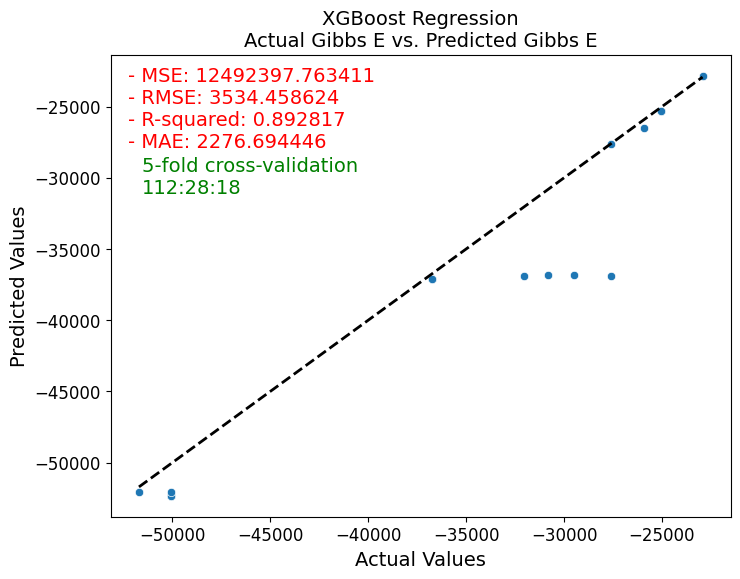

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) 
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('XGBoost Regression\nActual Gibbs E vs. Predicted Gibbs E', fontsize=14)

plt.text(0.028, 0.80, f'- MSE: {mse:.6f}\n- RMSE: {rmse:.6f}\n- R-squared: {r_squared:.6f}\n- MAE: {mae:.6f}', color='red', fontsize=14, transform=plt.gca().transAxes)
plt.text(0.050, 0.70, '5-fold cross-validation\n112:28:18', color='green', fontsize=14, ha='left', transform=plt.gca().transAxes)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [22]:
# ТОП-5 лучших предсказанных значений и величина абсолютной разницы

comparison_df = pd.DataFrame({'Actual Gibbs E': y_test, 'Predicted Gibbs E': y_pred})
print(comparison_df)

comparison_df['Absolute Difference'] = abs(comparison_df['Actual Gibbs E'] - comparison_df['Predicted Gibbs E'])
best_results = comparison_df.sort_values(by='Absolute Difference').head(5)
print("\n{: ^55}".format("TOP 5 Predicted Values:"))
print(best_results)

    Actual Gibbs E  Predicted Gibbs E
0    -27617.108248      -27602.658203
1    -27617.107555      -36907.054688
2    -25917.872472      -26534.613281
3    -29496.320185      -36832.000000
4    -22922.502813      -22829.658203
5    -25042.257575      -25285.673828
6    -25042.234179      -25289.597656
7    -25042.547512      -25303.234375
8    -36751.546845      -37074.054688
9    -36751.834471      -37097.914062
10   -50084.932513      -52296.640625
11   -50084.928225      -52327.718750
12   -50085.029196      -52319.898438
13   -50084.704241      -52327.828125
14   -51708.883453      -52100.710938
15   -50085.218923      -52097.773438
16   -32026.860716      -36883.472656
17   -30840.327107      -36857.625000

                TOP 5 Predicted Values:                
   Actual Gibbs E  Predicted Gibbs E  Absolute Difference
0   -27617.108248      -27602.658203            14.450045
4   -22922.502813      -22829.658203            92.844610
5   -25042.257575      -25285.673828           